#Install Dependencies

In [1]:
!pip install openvino
!apt-get install -y libgtk2.0-dev
!pip install numpy opencv-python-headless ipywidgets


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.5/40.5 MB 13.5 MB/s eta 0:00:00
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  autopoint debhelper debugedit dh-autoreconf dh-strip-nondeterminism dwz gettext gettext-base
  gir1.2-atk-1.0 gir1.2-freedesktop gir1.2-gdkpixbuf-2.0 gir1.2-gtk-2.0 gir1.2-harfbuzz-0.0
  gir1.2-pango-1.0 intltool-debian libarchive-cpio-perl libarchive-zip-perl libatk1.0-dev
  libblkid-dev libblkid1 libcairo-script-interpreter2 libcairo2-dev libdatrie-dev libdebhelper-perl
  libffi-dev libfile-stripnondeterminism-perl libfribidi-dev libgail-common libgail18
  libgdk-pixbuf-2.0-dev libgdk-pixbuf2.0-bin libglib2.0-dev libglib2.0-dev-bin libgraphite2-dev
  libgtk2.0-0 libgtk2.0-bin libgtk2.0-common libharfbuzz-dev libharfbuzz-gobject0 libharfbuzz-icu0
  libice-dev liblzo2-2 libmail-sendmail-perl libmount-dev libmount1 libpango1.0-dev
  libpangoxft-1.0-0 libpixman

#Download and Set Up Models

In [2]:
# Download face detection model
!wget https://storage.openvinotoolkit.org/repositories/open_model_zoo/2021.4/models_bin/1/face-detection-0204/FP16/face-detection-0204.xml
!wget https://storage.openvinotoolkit.org/repositories/open_model_zoo/2021.4/models_bin/1/face-detection-0204/FP16/face-detection-0204.bin

# Download emotion recognition model
!wget https://storage.openvinotoolkit.org/repositories/open_model_zoo/2021.4/models_bin/1/emotions-recognition-retail-0003/FP16/emotions-recognition-retail-0003.xml
!wget https://storage.openvinotoolkit.org/repositories/open_model_zoo/2021.4/models_bin/1/emotions-recognition-retail-0003/FP16/emotions-recognition-retail-0003.bin


--2024-08-05 05:32:08--  https://storage.openvinotoolkit.org/repositories/open_model_zoo/2021.4/models_bin/1/face-detection-0204/FP16/face-detection-0204.xml
Resolving storage.openvinotoolkit.org (storage.openvinotoolkit.org)... 3.163.125.65, 3.163.125.84, 3.163.125.13, ...
Connecting to storage.openvinotoolkit.org (storage.openvinotoolkit.org)|3.163.125.65|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 193280 (189K) [application/xml]
Saving to: ‘face-detection-0204.xml’

face-detection-0204 100%[===================>] 188.75K   474KB/s    in 0.4s    

2024-08-05 05:32:09 (474 KB/s) - ‘face-detection-0204.xml’ saved [193280/193280]

--2024-08-05 05:32:09--  https://storage.openvinotoolkit.org/repositories/open_model_zoo/2021.4/models_bin/1/face-detection-0204/FP16/face-detection-0204.bin
Resolving storage.openvinotoolkit.org (storage.openvinotoolkit.org)... 3.163.125.65, 3.163.125.84, 3.163.125.13, ...
Connecting to storage.openvinotoolkit.org (storage.openvin

#Load Models

In [3]:
from openvino.runtime import Core

core = Core()

# Load face detection model
face_model_path = "face-detection-0204.xml"
face_model = core.read_model(face_model_path)
compiled_face_model = core.compile_model(face_model, device_name="CPU")

# Load emotion recognition model
emotion_model_path = "emotions-recognition-retail-0003.xml"
emotion_model = core.read_model(emotion_model_path)
compiled_emotion_model = core.compile_model(emotion_model, device_name="CPU")


#Define Helper Function

In [4]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

# Preprocess input image
def preprocess_image(image, h, w):
    resized_image = cv2.resize(image, (w, h))
    input_image = np.expand_dims(resized_image.transpose(2, 0, 1), axis=0)
    return input_image

# Perform face detection
def detect_faces(image):
    input_blob = next(iter(compiled_face_model.inputs))
    n, c, h, w = input_blob.shape
    input_image = preprocess_image(image, h, w)
    output = compiled_face_model([input_image])
    return output

# Perform emotion recognition
def recognize_emotions(face_image):
    input_blob = next(iter(compiled_emotion_model.inputs))
    n, c, h, w = input_blob.shape
    input_image = preprocess_image(face_image, h, w)
    output = compiled_emotion_model([input_image])
    return output

# Annotate image with detections
def annotate_image(image, detections, emotions):
    for detection in detections.reshape(-1, 7):
        confidence = float(detection[2])
        if confidence > 0.5:
            xmin = int(detection[3] * image.shape[1])
            ymin = int(detection[4] * image.shape[0])
            xmax = int(detection[5] * image.shape[1])
            ymax = int(detection[6] * image.shape[0])
            face = image[ymin:ymax, xmin:xmax]
            emotion_output = recognize_emotions(face)
            emotion = np.argmax(emotion_output)
            emotion_text = ["neutral", "happy", "sad", "surprise", "anger"][emotion]
            cv2.rectangle(image, (xmin, ymin), (xmax, ymax), (255, 0, 0), 2)
            cv2.putText(image, emotion_text, (xmin, ymin - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 0, 0), 2)
    return image


#Process and Display Results

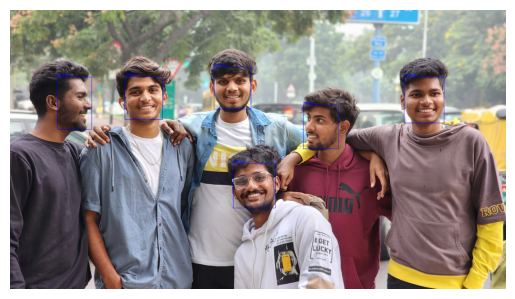

In [12]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

# ... (rest of the code)

# Annotate image with detections
def annotate_image(image, detections, emotions):
    # Extract detection results as a NumPy array
    detections = next(iter(detections.values()))
    for detection in detections.reshape(-1, 7):
        confidence = float(detection[2])
        if confidence > 0.5:
            xmin = int(detection[3] * image.shape[1])
            ymin = int(detection[4] * image.shape[0])
            xmax = int(detection[5] * image.shape[1])
            ymax = int(detection[6] * image.shape[0])
            face = image[ymin:ymax, xmin:xmax]
            emotion_output = recognize_emotions(face)
            emotion = np.argmax(emotion_output)
            emotion_text = ["neutral", "happy", "sad", "surprise", "anger"][emotion]
            cv2.rectangle(image, (xmin, ymin), (xmax, ymax), (255, 0, 0), 2)
            cv2.putText(image, emotion_text, (xmin, ymin - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 0, 0), 2)
    return image

# ... (rest of the code)
image_path = '/20231110_151022.JPG'
process_image(image_path)

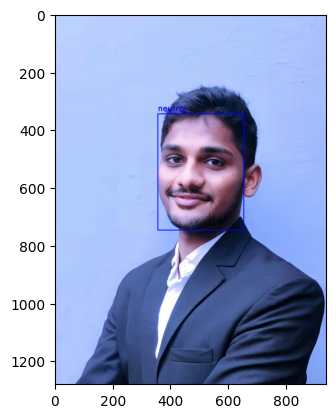

neutral


In [28]:

def process_image(image_path):
  image = cv2.imread(image_path)
  detections = detect_faces(image)
  annotated_image, emotions = annotate_image(image.copy(), detections) # Get the annotated image and emotions
  plt.imshow(cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB))
  plt.show()

  # Print the detected emotions
  for emotion in emotions:
    print(emotion)

image_path = '/pic.jpg'
process_image(image_path)
